In [118]:
import torch
import numpy as np 
from matplotlib import pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import pickle
%matplotlib inline

In [121]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='data', train=True,
                                        download=True, transform=transform)
nb_train = 50000
trainloader = torch.utils.data.DataLoader(trainset, 
                                           sampler=SubsetRandomSampler(np.arange(nb_train)),
                                           batch_size=64)

validloader = torch.utils.data.DataLoader(trainset, 
                                           sampler=SubsetRandomSampler(np.arange(nb_train, len(trainset))),
                                           batch_size=64)

testset = torchvision.datasets.MNIST(root='data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

In [122]:
print(len(trainloader))
print(len(validloader))
print(len(testloader))

782
157
157


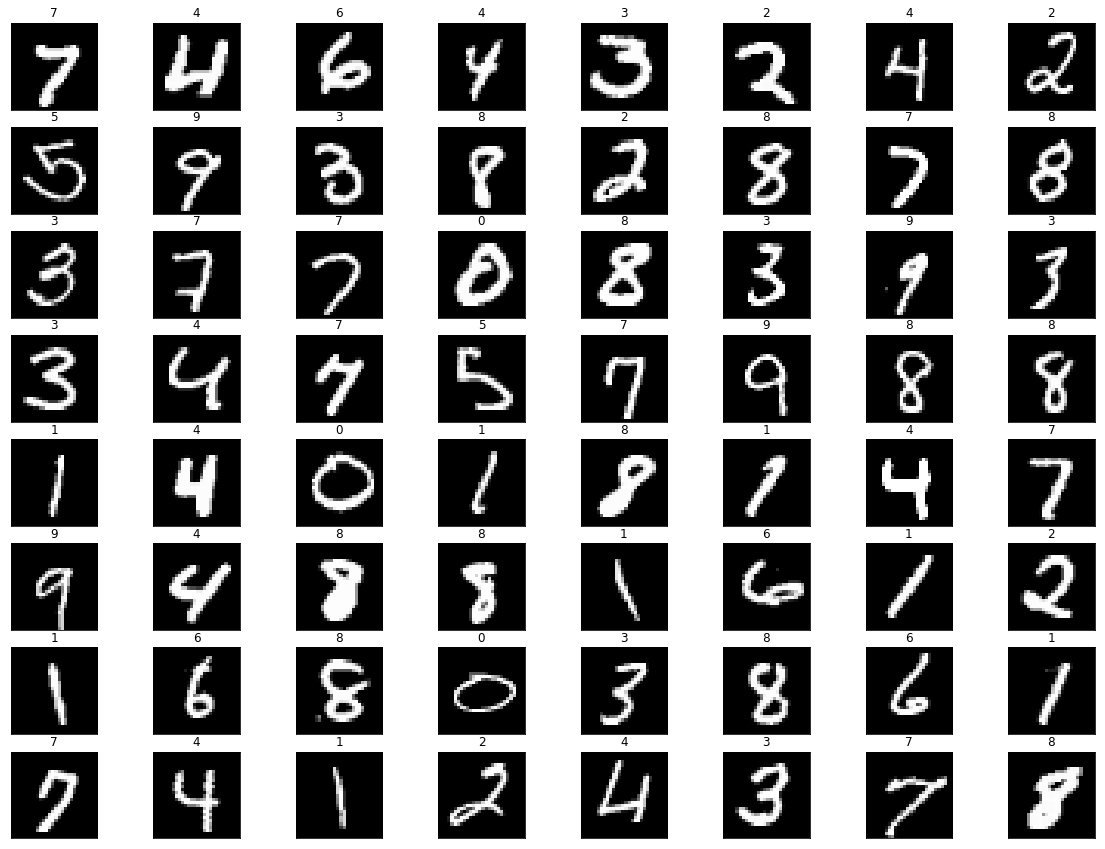

In [123]:
def imshow(ax, img, label):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    ax.imshow(npimg[0], cmap='gray')
    ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    right='off',
    left='off',
    labelbottom='off',
    labelleft='off') # labels along the bottom edge are off
    ax.set_title(label)

plt.rcParams['figure.figsize'] = (20, 15)
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
plot_sz = int(np.sqrt(len(images)))
fig, axes = plt.subplots(plot_sz, plot_sz)
for i, image in enumerate(images):
    imshow(axes[int(i/plot_sz), i%plot_sz], image, labels[i])

In [92]:
class Net(nn.Module):
    def __init__(self, layer_sizes=None):
        super(Net, self).__init__()
        if layer_sizes is None:
            layer_sizes = [28 * 28, 800, 800, 10]
        self.sizes = layer_sizes
        layers = []
        for i in range(len(layer_sizes) - 2):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1], bias=True))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1], bias=True))
        self.predict_ = nn.Sequential(*layers)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        #print(x.shape)
        x = x.view(-1, self.sizes[0])
        #print(x.shape)
        return self.predict_(x)
    
    def predict_proba(self, x):
        return nn.Softmax(dim=1)(self.forward(x))
    
    def predict(self, x):
        return torch.max(self.predict_proba(x), 1)[1]
    
    def loss(self, x, target):
        pre_softmax = self(x)
        return self.criterion(pre_softmax, target)

net = Net()
print([param.size() for param in list(net.parameters())])

[torch.Size([800, 784]), torch.Size([800]), torch.Size([800, 800]), torch.Size([800]), torch.Size([10, 800]), torch.Size([10])]


In [104]:
def init_glorot(m):
    gain = nn.init.calculate_gain('relu')
    if type(m) == nn.Linear:
        nn.init.xavier_uniform(m.weight,gain=gain)
        nn.init.constant(m.bias,0)

In [133]:
len(validloader.sampler)

10000

In [157]:
def error_accuracy(mlp, loader):
    loss = 0
    correct = 0
    for data, target in loader:
        if torch.cuda.is_available:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = mlp(data)
        loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = mlp.predict(data)
        correct += pred.data.eq(target.data.view_as(pred)).cpu().sum()

    loss /= len(loader.sampler)
    accuracy = correct / len(loader.sampler)
    error = 1 - accuracy
    #print('Average loss: {:.4f}, Error: {}/{} ({:.0f}%)'.format(
    #    loss, len(loader.sampler) - correct, len(loader.sampler),
    #    100. * error))
    
    return loss, error

In [249]:
def param_norms(mlp):
    norm_sq = 0
    for param in list(mlp.parameters()):
        if param.ndimension()==2:
            norm_sq += param.norm(2).data[0]**2
    #print(norm_sq)
    return np.sqrt(norm_sq)

In [261]:
def train(layer_sizes=None, n_epochs=100, lr=0.1, l2reg=2.5, print_every=200, print_every_meta=10):
    net = Net(layer_sizes)
    if torch.cuda.is_available:
        print('Using CUDA')
        net = net.cuda()
    optimizer = optim.SGD(net.parameters(), lr=0.001, weight_decay=l2reg)
    net.apply(init_glorot)
    train_losses, train_errors, valid_losses, valid_errors = [], [], [], []
    norms = []
    train_loss, train_error = error_accuracy(net, trainloader)
    valid_loss, valid_error = error_accuracy(net, validloader)
    norm = param_norms(net)
    print("Epoch {}: (train_error: {:.2e}, valid_error: {:.2e})".format(0, train_error, valid_error))
    print('Norm of param: {:.2e}'.format(norm))
    norms.append(norm)
    train_losses.append(train_loss)
    train_errors.append(train_error)
    valid_losses.append(valid_loss)
    valid_errors.append(valid_error)
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            if torch.cuda.is_available:
                inputs = inputs.cuda()
                labels = labels.cuda()
            inputs, labels = Variable(inputs), Variable(labels)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = net.loss(inputs, labels)
            loss.backward()
            optimizer.step()
            norm = param_norms(net)
            norms.append(norm)
            running_loss += loss.data[0]
            if i % print_every == print_every - 1:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / print_every))
                running_loss = 0.0
        train_loss, train_error = error_accuracy(net, trainloader)
        valid_loss, valid_error = error_accuracy(net, validloader)
        
        if epoch%print_every_meta == print_every_meta - 1:
            print("Epoch {}: (train_error: {:.2e}, valid_error: {:.2e})".format(epoch + 1, train_error, valid_error))
            print('Norm of param: {:.3f}'.format(norm))
        train_losses.append(train_loss)
        train_errors.append(train_error)
        valid_losses.append(valid_loss)
        valid_errors.append(valid_error)
        

    return ({'train_losses': train_losses,
            'train_errors': train_errors,
            'valid_losses': valid_losses,
            'valid_errors': valid_errors,
            'norms': norms}, net)

In [262]:
out_data, net = train(print_every=9999, lr=0.02, l2reg=0)

Using CUDA
Epoch 0: (train_error: 9.24e-01, valid_error: 9.29e-01)
Norm of param: 5.68e+01
Epoch 10: (train_error: 7.10e-02, valid_error: 6.77e-02)
Norm of param: 56.856
Epoch 20: (train_error: 5.42e-02, valid_error: 5.13e-02)
Norm of param: 56.894
Epoch 30: (train_error: 4.33e-02, valid_error: 4.35e-02)
Norm of param: 56.929
Epoch 40: (train_error: 3.67e-02, valid_error: 4.02e-02)
Norm of param: 56.962
Epoch 50: (train_error: 3.15e-02, valid_error: 3.71e-02)
Norm of param: 56.994
Epoch 60: (train_error: 2.81e-02, valid_error: 3.42e-02)
Norm of param: 57.025
Epoch 70: (train_error: 2.36e-02, valid_error: 3.20e-02)
Norm of param: 57.054
Epoch 80: (train_error: 2.10e-02, valid_error: 3.18e-02)
Norm of param: 57.082
Epoch 90: (train_error: 1.85e-02, valid_error: 3.02e-02)
Norm of param: 57.110
Epoch 100: (train_error: 1.65e-02, valid_error: 2.88e-02)
Norm of param: 57.136


In [263]:
pickle.dump(out_data, open('data_lr_0.02_l2reg_0.pkl', 'wb'))

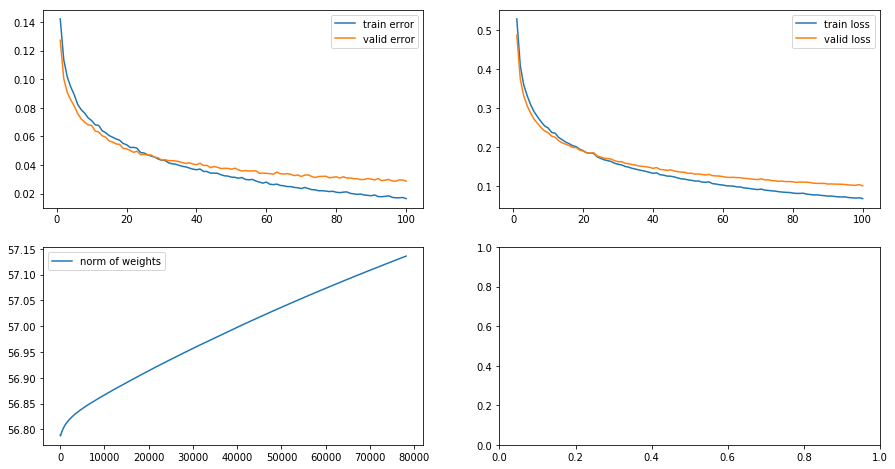

In [264]:
plt.rcParams['figure.figsize'] = (15, 8)
fig, axes=plt.subplots(2, 2)
axes[1, 0].plot(out_data['norms'], label='norm of weights')
axes[1, 0].legend()
axes[0, 0].plot(range(1, 101), out_data['train_errors'][1:], label='train error')
axes[0, 0].plot(range(1, 101), out_data['valid_errors'][1:], label='valid error')
axes[0, 0].legend()
axes[0, 1].plot(range(1, 101), out_data['train_losses'][1:], label='train loss')
axes[0, 1].plot(range(1, 101), out_data['valid_losses'][1:], label='valid loss')
axes[0, 1].legend()
plt.show()

In [258]:
out_data, net = train(print_every=9999, lr=0.02, l2reg=2.5)

Using CUDA
Epoch 0: (train_error: 8.68e-01, valid_error: 8.66e-01)
Norm of param: 5.68e+01
Epoch 10: (train_error: 8.86e-01, valid_error: 8.94e-01)
Norm of param: 1.79e-07
Epoch 20: (train_error: 8.86e-01, valid_error: 8.94e-01)
Norm of param: 5.66e-16
Epoch 30: (train_error: 8.86e-01, valid_error: 8.94e-01)
Norm of param: 0.00e+00
Epoch 40: (train_error: 8.86e-01, valid_error: 8.94e-01)
Norm of param: 0.00e+00
Epoch 50: (train_error: 8.86e-01, valid_error: 8.94e-01)
Norm of param: 0.00e+00
Epoch 60: (train_error: 8.86e-01, valid_error: 8.94e-01)
Norm of param: 0.00e+00
Epoch 70: (train_error: 8.86e-01, valid_error: 8.94e-01)
Norm of param: 0.00e+00
Epoch 80: (train_error: 8.86e-01, valid_error: 8.94e-01)
Norm of param: 0.00e+00
Epoch 90: (train_error: 8.86e-01, valid_error: 8.94e-01)
Norm of param: 0.00e+00
Epoch 100: (train_error: 8.86e-01, valid_error: 8.94e-01)
Norm of param: 0.00e+00


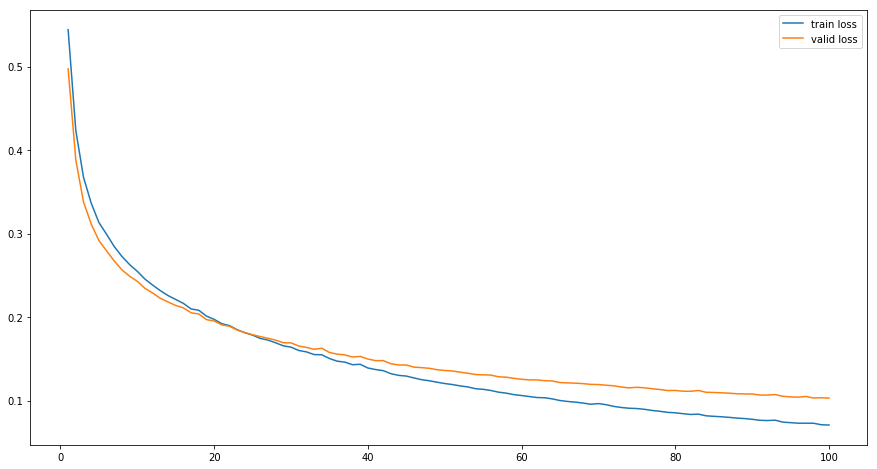

In [255]:
plt.rcParams['figure.figsize'] = (15, 8)
plt.plot(range(1, 101), out_data['train_losses'][1:], label='train loss')
plt.plot(range(1, 101), out_data['valid_losses'][1:], label='valid loss')
plt.legend()
plt.show()